# Getting Started with `cvxpy` for Portfolio Optimization

This notebook is a **lightweight introduction to `cvxpy`** aimed at enabling you to:
- translate mathematical convex optimization problems into code,
- solve basic portfolio optimization problems,
- inspect and visualize results.

We assume you are already comfortable with:
- convex optimization terminology (objective, constraints, convexity),
- basic portfolio concepts (returns, covariance, weights),
- Python (NumPy, Pandas)

---

## 1. What is `cvxpy`?

`cvxpy` is a Python library for **disciplined convex programming (DCP)**.  
You describe an optimization problem in a way that mirrors the mathematics, and `cvxpy`:
- verifies convexity automatically,
- converts the problem to a standard form,
- calls an appropriate numerical solver.

You do **not** implement algorithms yourself; your responsibility is **correct formulation**.

Official documentation:  
https://www.cvxpy.org/

---



## 2. Basic structure of a `cvxpy` program

Every `cvxpy` optimization problem has three components:

1. **Variables**
2. **Objective**
3. **Constraints**

### Minimal example

Key points:

* Variables are symbolically defined via `cp.Variable`.
* You build expressions using standard Python operators.
* `.solve()` triggers numerical optimization.
* `.value` extracts the numerical result.

In [2]:
import cvxpy as cp
import numpy as np

# variable
x = cp.Variable()

# objective = (x+1)^2
objective = cp.Minimize((x + 1)**2)

# constraints = x>=0
constraints = [x >= 0]

# problem
problem = cp.Problem(objective, constraints)

# solve
problem.solve()

print("Optimal x:", x.value)
print("Optimal value:", problem.value)

# Expected output:
# Optimal x: 0.0
# Optimal value: 1.0


Optimal x: -1.399919957976194e-29
Optimal value: 1.0


## 3. Vectors, matrices, and quadratic forms

Portfolio optimization is vector-valued. Common patterns:

### Vector variable


In [3]:
n = 5
w = cp.Variable(n)

### Linear expressions


In [4]:
mu = np.random.randn(n)
ret = mu @ w            # inner product

### Quadratic forms
For covariance matrices:
⚠️ `Sigma` **must be symmetric and positive semidefinite** for convexity.


In [5]:

Sigma = np.eye(n)  # defines nxn identity
risk = cp.quad_form(w, Sigma)   # w^T Sigma w


## 4. Objectives: maximize vs minimize

`cvxpy` distinguishes explicitly:

```python
cp.Minimize(expression)
cp.Maximize(expression)
```

Example of the risk penalized form of markowitz optimization (see README.ipynb Sec 3.1)


In [6]:
lam = 0.5
objective = cp.Maximize(mu @ w - lam * cp.quad_form(w, Sigma))

## 5. Constraints: common patterns in portfolio optimization

### Budget constraint

```python
cp.sum(w) == 1
```

### Long-only constraint

```python
w >= 0
```

### Box constraints (optional)

```python
w <= 0.2
```

Constraints are always passed as a **list**.

---



## 6. Complete example: basic Markowitz portfolio

1. Look at the definition and the cvxpy code for the actual optimization routine below. This is the general pattern for using cvxpy for convex problems.
2. Look at code for defining variables using numpy and visualizing them
3. Look at the code for visualizing and comparing portfolios:
    - Comparing weight allocations
    - Comparing (expected portfolio return, portfolio risk) with respect to the "efficient frontier"

Note: these helpers are defined in `helpers.py`. Please review the file to understand their usage. They will be used in the tasks to make your work easier.

In [3]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------
# Helper Routine: solve Markowitz problem
# -------------------------------
def markowitz_portfolio(mu, Sigma, lam):
    """
    Solve the long-only Markowitz problem:
        max_w  mu^T w - lam * w^T Sigma w
        s.t.   1^T w = 1, w >= 0
    """
    n = len(mu)
    w = cp.Variable(n)

    objective = cp.Maximize(mu @ w - lam * cp.quad_form(w, Sigma))
    constraints = [
        cp.sum(w) == 1,
        w >= 0
    ]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    w_opt = w.value
    exp_ret = mu @ w_opt
    var = w_opt.T @ Sigma @ w_opt

    return w_opt, exp_ret, var


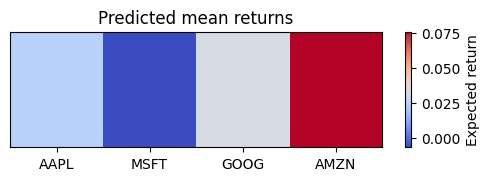

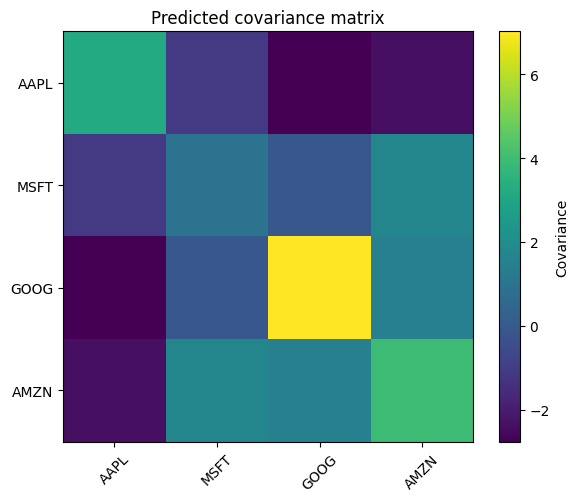

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from helpers import (
    save_predictions,
    load_predictions,
    plot_mu_and_cov,
    visualize_weights_stacked,
    visualize_return_risk,
    compute_sharpe_ratios,
    plot_sharpe_ratios,
    print_sharpe_table,
)

# ============================================================
# 1. Generate synthetic data (stand-in for Week 3 predictions)
# ============================================================

np.random.seed(42)

tickers = ["AAPL", "MSFT", "GOOG", "AMZN"]
n = len(tickers)

# Synthetic mean returns
mu = 0.05 * np.random.randn(n)

# Synthetic covariance (PSD by construction)
B = np.random.randn(n, n)
Sigma = B @ B.T + 1e-2 * np.eye(n)

# Save predictions to disk
save_predictions(mu, Sigma, tickers)

# ============================================================
# 2. Load predictions (Week 4 optimization starts here)
# ============================================================

mu, Sigma, tickers = load_predictions()

# Visual sanity check
plot_mu_and_cov(mu, Sigma, tickers)


In [14]:
# ============================================================
# 3. Sweep over risk-aversion parameter lambda
# ============================================================

lams = np.logspace(-2, 2, 20)
lam_labels = [f"{lam:.2e}" for lam in lams]

weights = []
returns = []
variances = []

for lam in lams:
    # markowitz_portfolio should return:
    #   w_opt: optimal weights
    #   r: expected return
    #   v: variance
    w_opt, r, v = markowitz_portfolio(mu, Sigma, lam)

    weights.append(w_opt)
    returns.append(r)
    variances.append(v)

weights = np.array(weights)      # shape: (n_lambda, n_assets)
returns = np.array(returns)      # shape: (n_lambda,)
variances = np.array(variances)  # shape: (n_lambda,)


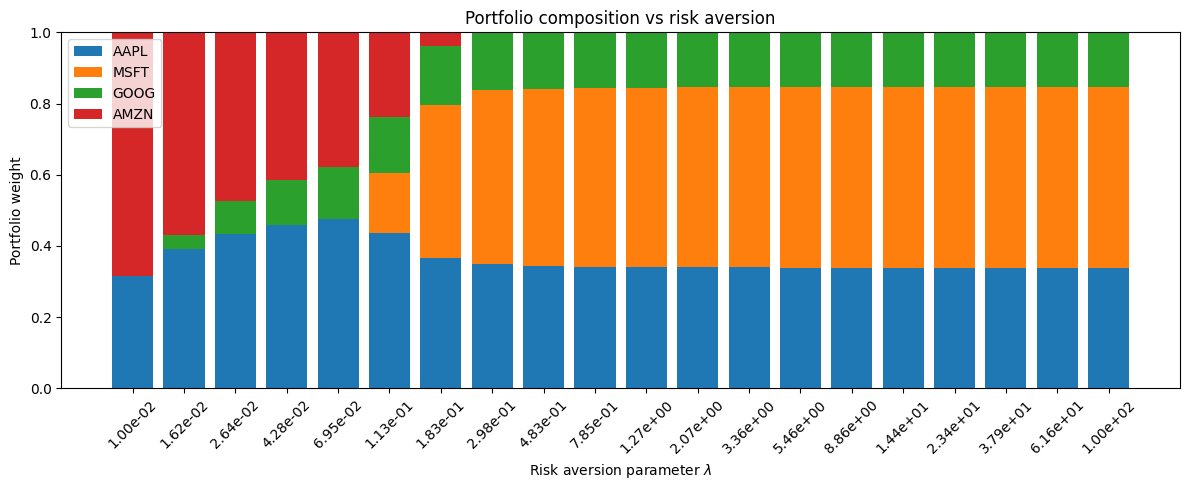

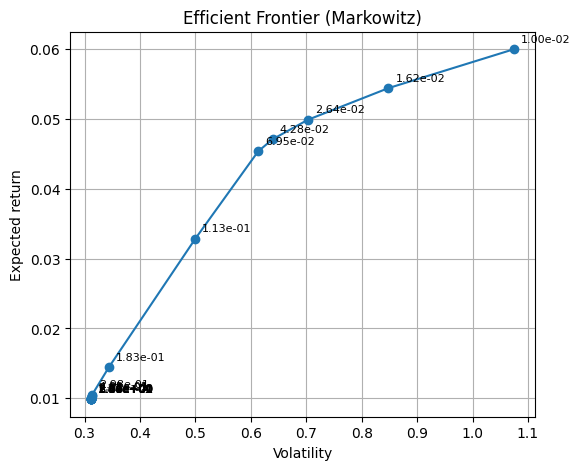

In [15]:

# ============================================================
# 4. Visualize results
# ============================================================

# Portfolio composition vs lambda
visualize_weights_stacked(
    weights,
    labels=lam_labels,
    tickers=tickers,
)

# Efficient frontier
visualize_return_risk(
    returns,
    variances,
    labels=lam_labels,
    use_volatility=True,
)


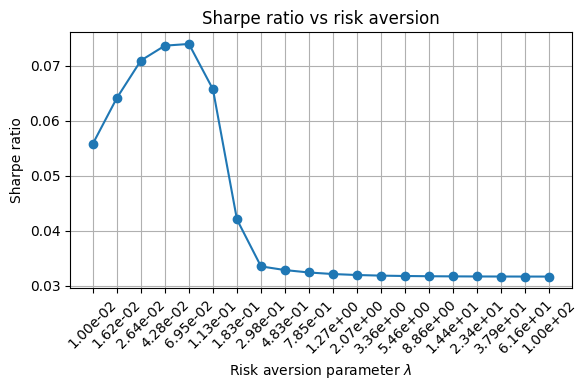

         λ |     Return |   Volatility |     Sharpe
----------------------------------------------------
  1.00e-02 |     0.0600 |       1.0747 |     0.0558
  1.62e-02 |     0.0544 |       0.8483 |     0.0641
  2.64e-02 |     0.0499 |       0.7030 |     0.0709
  4.28e-02 |     0.0471 |       0.6393 |     0.0736
  6.95e-02 |     0.0454 |       0.6134 |     0.0739
  1.13e-01 |     0.0329 |       0.5000 |     0.0657
  1.83e-01 |     0.0145 |       0.3440 |     0.0420
  2.98e-01 |     0.0105 |       0.3137 |     0.0335
  4.83e-01 |     0.0103 |       0.3126 |     0.0328
  7.85e-01 |     0.0101 |       0.3122 |     0.0324
  1.27e+00 |     0.0100 |       0.3121 |     0.0321
  2.07e+00 |     0.0100 |       0.3120 |     0.0319
  3.36e+00 |     0.0099 |       0.3120 |     0.0318
  5.46e+00 |     0.0099 |       0.3120 |     0.0318
  8.86e+00 |     0.0099 |       0.3120 |     0.0317
  1.44e+01 |     0.0099 |       0.3120 |     0.0317
  2.34e+01 |     0.0099 |       0.3120 |     0.0317
  3.79e+01 

In [16]:

# ============================================================
# 5. Sharpe ratio analysis
# ============================================================

sharpe, ret, var = compute_sharpe_ratios(weights, mu, Sigma)

# Plot Sharpe vs lambda
plot_sharpe_ratios(sharpe, labels=lam_labels)

# Optional: print table
print_sharpe_table(
    labels=lam_labels,
    sharpe=sharpe,
    returns=ret,
    variances=var,
)


## Observe
Large lambda corresponds to **least risk** portfolios while low lambda corresponds to **risky high return** portfolios.

## 7. Norms and robustness-friendly expressions

`cvxpy` supports standard norms:

```python
cp.norm(w, 1)     # ℓ1 norm
cp.norm(w, 2)     # ℓ2 norm
cp.norm(w, "inf") # ℓ∞ norm
```

These are useful for regularization and robustness implementations.

---



## 8. Solvers and diagnostics

By default, `cvxpy` chooses a solver automatically.
You can inspect status:

```python
print(problem.status)
```

Common statuses:

* `optimal`
* `optimal_inaccurate`
* `infeasible`
* `unbounded`

For most problems in this course, the default solver is sufficient.

---



## 9. Visualizing results

Use `matplotlib.pyplot` to visualize your portfolios

```python
import matplotlib.pyplot as plt

plt.bar(range(n), w.value)
plt.title("Portfolio Weights")
plt.show()

# or compare two portfolios
plt.plot(w1, label="Portfolio 1")
plt.plot(w2, label="Portfolio 2")
plt.legend()
plt.show()
```

---



## 10. Good practices

* Always **check convexity assumptions** (PSD matrices, affine constraints).
* Start with **simple constraints**, then add complexity.
* Inspect your solutions
* Comment your modeling choices.

---
